In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import cv2
import pandas
import random
import faiss
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import axes3d
from  PIL import Image
from time import time
from torch import nn
from torchvision import models
from torchvision import transforms
from torchvision import datasets
from torch.utils.data.dataset import Dataset
from torchsummary import summary

from sklearn.decomposition import PCA
from sklearn import preprocessing

torch.cuda.is_available()

False

In [2]:
dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'MobileNetV3',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mobilenetv2',
 'mobilenetv3',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 '

In [60]:

resnet = models.resnet152(pretrained=True)
# freeze all base layers; Parameters of newly constructed modules have requires_grad=True by default
for param in resnet.parameters():
    param.requires_grad = False
num_ftrs = resnet.fc.in_features

# # add final layers tot he network
# resnet.fc = nn.Sequential(
#     nn.Linear(num_ftrs, 1000),
#     nn.Linear(1000,3)
#     )

# print(list(resnet.parameters()))



    # verify what the network end looks like
summary(resnet, input_size= (3,244,244))


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to C:\Users\pablos/.cache\torch\hub\checkpoints\resnet152-b121ed2d.pth
100%|██████████| 230M/230M [04:48<00:00, 837kB/s] 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]           4,096
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
           Conv2d-11          [-1, 

In [71]:
print(num_ftrs)

2048


In [61]:
def load_images_from_folder(folder, end, as_tensor = False):
        
    images = []
    num_img = []
    file_count= 0
    dirnames = [] 

 

    for _, dirnames, filenames in os.walk(folder):

 

        if dirnames != []:
            subfolders = dirnames
        current_path = os.path.join(folder, subfolders[file_count])
        num_img.append(len(os.listdir(current_path)))
        for filename in os.listdir(current_path):
                if as_tensor:
                    img = cv2.imread(os.path.join(current_path, filename))
                    if img is not None:    
                        img = torch.from_numpy(img).type(torch.uint8)               
                        images.append(img)
                        
                else:
                    img = Image.open(os.path.join(current_path, filename))
                    if img is not None:    
                        images.append(img)

 

        file_count += 1
        
        if file_count % 10 == 0:
            print('number of folder done =', file_count, 'total number of images so far =', len(images))
            
        if file_count  == end:
            return images, num_img

    return images, num_img


def show_image(PIL_img):
    PIL_img.show()


In [62]:

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy()
    inp.transpose((0, 2, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def show_tensor_image(image_tensor, preprocess = False):
    # use this code when showing the images
    inp = image_tensor.numpy()
    if preprocess:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

    im2 = inp.copy()
    im2[:, :, 0] = image_tensor[:, :, 2]
    im2[:, :, 2] = image_tensor[:, :, 0]
    plt.imshow(im2)


In [56]:
path = r"D:\Pablo\Uni Work\uob_image_set\uob_image_set"

N_CHANNELS = 3

images, num_images = load_images_from_folder(path, 100, as_tensor= False)
# show_image(images[0])
num_images





number of folder done = 10 total number of images so far = 42
number of folder done = 20 total number of images so far = 87
number of folder done = 30 total number of images so far = 128
number of folder done = 40 total number of images so far = 175
number of folder done = 50 total number of images so far = 219
number of folder done = 60 total number of images so far = 265
number of folder done = 70 total number of images so far = 307
number of folder done = 80 total number of images so far = 349
number of folder done = 90 total number of images so far = 390
number of folder done = 100 total number of images so far = 436


[5,
 4,
 4,
 5,
 4,
 3,
 4,
 4,
 5,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 4,
 4,
 5,
 4,
 3,
 3,
 5,
 5,
 5,
 4,
 3,
 5,
 4,
 5,
 5,
 5,
 5,
 3,
 5,
 5,
 5,
 5,
 4,
 3,
 4,
 5,
 5,
 4,
 5,
 5,
 5,
 5,
 3,
 5,
 5,
 5,
 5,
 5,
 3,
 5,
 5,
 3,
 5,
 5,
 5,
 5,
 5,
 5,
 3,
 2,
 3,
 4,
 5,
 4,
 5,
 5,
 2,
 5,
 3,
 5,
 5,
 5,
 3,
 3,
 5,
 5,
 4,
 2,
 4,
 5,
 5,
 5,
 3,
 4,
 5,
 5,
 5,
 4,
 3,
 5,
 5,
 5,
 5]

In [7]:
# loading data in batches and show a grid of them
#  reconsider how to load data
# full_loader = torch.utils.data.DataLoader(images, shuffle=False, num_workers=os.cpu_count())
# print(full_loader)

#     # Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

In [63]:
# using the mean and std values form the ImageNet data for which it was pretrained
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )])


In [64]:


def preprocess_and_batch(image_list):
    list_input_tensor = []
    list_input_batch = []
    
    for item in range(len(image_list)):
        input_tensor = preprocess(image_list[item])
        input_batch = input_tensor.unsqueeze(0)
        list_input_tensor.append(input_tensor)
        list_input_batch.append(input_batch)
    return list_input_batch, list_input_tensor

list_input_batch, list_input_tensor= preprocess_and_batch(images)
print(list_input_batch)


..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          ..

In [65]:

def feed_batch_to_network(list_input_batch, network):
    output_array = []
    for i in range(len(list_input_batch)):
        if torch.cuda.is_available():
            input_batch = list_input_batch[i].to('cuda')
            resnet.to('cuda')
        else:
            input_batch = list_input_batch[i].to('cpu')
            resnet.to('cpu')
            
        with torch.no_grad():
            output = network(input_batch)
            cpu_tensor = output.cpu()
            pos = cpu_tensor[0].tolist()       
            output_array.append(pos)
    output_array = np.asarray(output_array)
    display(output_array)


    return output_array


network_output = feed_batch_to_network(list_input_batch, resnet)
print(network_output)


array([[-0.87257105, -0.42776179, -0.55376732, ..., -0.3369703 ,
         0.96599889,  0.85653371],
       [-0.89156222, -0.41113129, -0.5319649 , ..., -0.52237183,
         0.93794453,  0.85287398],
       [-0.87800139, -0.38868538, -0.47079828, ..., -0.33550626,
         0.96332955,  0.93792689],
       ...,
       [-0.76905411, -0.4234885 , -0.75202811, ..., -0.46579635,
         1.03779864,  0.70590258],
       [-0.90953237, -0.37396371, -0.60056043, ..., -0.63292116,
         0.82405758,  0.76804644],
       [-0.89785314, -0.43536788, -0.73417199, ..., -0.47206423,
         0.96139807,  0.81890875]])

[[-0.87257105 -0.42776179 -0.55376732 ... -0.3369703   0.96599889
   0.85653371]
 [-0.89156222 -0.41113129 -0.5319649  ... -0.52237183  0.93794453
   0.85287398]
 [-0.87800139 -0.38868538 -0.47079828 ... -0.33550626  0.96332955
   0.93792689]
 ...
 [-0.76905411 -0.4234885  -0.75202811 ... -0.46579635  1.03779864
   0.70590258]
 [-0.90953237 -0.37396371 -0.60056043 ... -0.63292116  0.82405758
   0.76804644]
 [-0.89785314 -0.43536788 -0.73417199 ... -0.47206423  0.96139807
   0.81890875]]


In [11]:
network_output

array([[-6.64605573e-03, -2.63872445e-01, -1.34154409e-01],
       [ 1.51505284e-02, -2.67427981e-01, -1.48230314e-01],
       [ 1.31390989e-04, -2.86504239e-01, -1.46545753e-01],
       [-5.04004210e-03, -2.67067850e-01, -1.56737119e-01],
       [ 1.34591907e-02, -2.57734925e-01, -1.38365135e-01],
       [-2.10299343e-03, -2.71055937e-01, -1.48193002e-01],
       [ 3.48029658e-03, -2.61350155e-01, -1.48271129e-01],
       [-6.93220645e-04, -2.79870987e-01, -1.48347914e-01],
       [ 1.47357918e-02, -2.81132668e-01, -1.18981048e-01],
       [-2.47896835e-03, -2.47999966e-01, -1.19427249e-01],
       [ 2.79124454e-03, -2.52377868e-01, -1.28640503e-01],
       [ 1.39698051e-02, -2.56321192e-01, -1.14934213e-01],
       [ 2.46830285e-03, -2.71891952e-01, -1.29723415e-01],
       [ 6.25713542e-03, -2.68231750e-01, -1.46111503e-01],
       [-3.52976844e-03, -2.62848109e-01, -1.37801081e-01],
       [-1.53095163e-02, -2.63902485e-01, -1.40089691e-01],
       [ 8.54219124e-03, -2.58724004e-01

In [66]:

def output_3d_plot(num_images):

    fig = plt.figure()
    ax = plt.axes(projection="3d")

    img_counter = 0
    for n in num_images:
        r = lambda: random.randint(0,255)
        random_color = '#%02X%02X%02X' % (r(),r(),r())
        ax.scatter(network_output[img_counter:img_counter + n,0], network_output[img_counter:img_counter + n,1], network_output[img_counter:img_counter + n,2],color=random_color,s=20)
        img_counter += n


    ax.set_xlabel('X Axes')
    ax.set_ylabel('Y Axes')
    ax.set_zlabel('Frame Axes')

    plt.show()


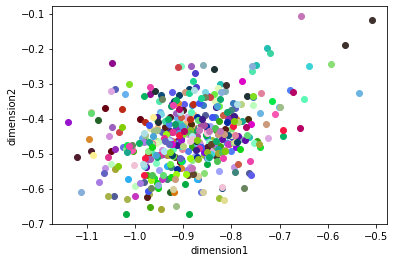

In [67]:
def output_2d_plot(network_output,num_images, dimension_1, dimension_2):
    # dimension numbers = 0, 1, 2
    fig = plt.figure()
    img_counter = 0
    for n in num_images:
        r = lambda: random.randint(0,255)
        random_color = '#%02X%02X%02X' % (r(),r(),r())
        plt.plot(network_output[img_counter:img_counter + n,dimension_1],network_output[img_counter:img_counter + n,dimension_2], 'o',color=random_color)
        img_counter += n
    plt.xlabel("dimension1")
    plt.ylabel("dimension2")
    plt.show()            
output_2d_plot(network_output,num_images, 0, 1)

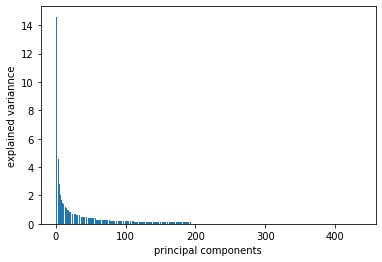

In [68]:
scaled_data = preprocessing.scale(network_output)
pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
per_var

labels = ['PC' +  str(x) for x in range(1,len(per_var)+1)]
plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.xlabel("principal components")
plt.ylabel("explained variannce")
plt.show()

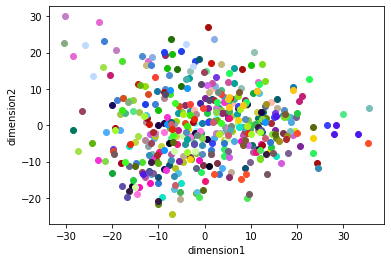

In [69]:

pca_df = pd.DataFrame(pca_data, columns=labels)

def pca_2d_plot(pca_df, num_images, dimension_1, dimension_2):
    fig = plt.figure()
    img_counter = 0
    for n in num_images:
        r = lambda: random.randint(0,255)
        random_color = '#%02X%02X%02X' % (r(),r(),r())
        plt.plot(dimension_1[img_counter:img_counter + n], dimension_2[img_counter:img_counter + n], 'o',color=random_color)
        img_counter += n
    plt.xlabel("dimension1")
    plt.ylabel("dimension2")
    plt.show()
pca_2d_plot(pca_df, num_images, pca_df.PC1,  pca_df.PC2)

In [98]:

n = sum(num_images)    # number of vectors                   
print(dimensions)
print(network_output[0].shape)


2048
(1000,)


In [73]:
def train_index(index, expected_num_images = None):

    if index.is_trained:
        return print("index has been trained")
    index.train(db_vectors)  # train on the database vectors
    print(index.ntotal)   # 0
    index.add(db_vectors)   # add the vectors and update the index
    print(index.is_trained)  # True
    print(index.ntotal)   # number of images
    print("equal", len(images) == index.ntotal)
    if expected_num_images is not None:
        assert index.ntotal == expected_num_images, "index total does not match expected number of images"

train_index(index, n)

NameError: name 'index' is not defined

In [99]:
def check_embedding_type(embeddings):
    # add vectors to index. Embeddings can be Numpy arrays or torch tensors

    if embeddings.dtype != 'float32':
        try:
            embeddings = np.float32(embeddings)
        except:
            raise  Exception('cannot convert embeddings into float32 array please check its datatype')
    return embeddings

def search_n_clusters(embeddings, num_clusters, nprobe, num_results, vector_dimension):
 
 
    if nprobe > num_clusters:
        raise Exception("number of clsuters probed should be less than or equal to the number of clusters")
    embeddings = check_embedding_type(embeddings)
    # to assign the vectors to a particular cluster. This is usually another index that uses the L2 distance metric (we use the FlatL2 index)
    quantiser = faiss.IndexFlatL2(vector_dimension)  
    # create the partitioned index
    index = faiss.IndexIVFFlat(quantiser, vector_dimension, num_clusters,   faiss.METRIC_L2)
   
    index.nprobe = nprobe  # nprobe parameter specifies the number of clusters to visit during the search operation (nprobe <= num_clusters); hyper-parameter which can be tuned for different results
    
    index.train(embeddings)
    index.add(embeddings)  
   
    #  search operation will return the ids (row numbers or index in the vector store) of the k most similar vectors for each query vector along with their respective          distances
    # ‘num results’ specifies the number of similar vectors to be returned from the visited clusters.
    
    distances, indices = index.search(embeddings, num_results)

    return distances, indices

# -1 indices indicates no image assignment given number of clusters
distances, indices = search_n_clusters(network_output, 2, 2, 6, 1000)
print(distances, indices)

[[ 0.         7.381429   8.188507   8.305346   8.900734   9.008152 ]
 [ 0.         9.331522  10.859322  10.943331  11.014402  11.3985815]
 [ 0.         7.16287    7.381429   8.159601   8.315997   8.826054 ]
 ...
 [ 0.        11.298447  11.770875  12.113956  12.338285  12.943928 ]
 [ 0.         7.4752016  8.062888  10.365601  10.564986  11.176931 ]
 [ 0.         7.4752016  8.315802   8.560174   9.010618   9.256977 ]] [[  0   2 237   3 346 169]
 [  1 162 406   2 240   3]
 [  2 304   0 418   3 168]
 ...
 [433 431 434 432 428   9]
 [434 435 432  78  52 428]
 [435 434  78 425 133  13]]


In [101]:


def search_flat_index(vector_dimension, embeddings, num_NN, save = False):
    
    # add vectors to index. Embeddings can be Numpy arrays or torch tensors
    embeddings = check_embedding_type(embeddings)   
    index = faiss.IndexFlatL2(vector_dimension)
    index.add(embeddings) 
    top_NN = num_NN
    distances, neighbours = index.search(embeddings, k= top_NN)
    if save:
        faiss.write_index(index, 'embedding_lookup_index')
    return distances, neighbours

distances, neighbours = search_flat_index(1000, network_output, 6)

In [102]:
print(distances, neighbours)

[[0.00000000e+00 7.38256836e+00 8.18835449e+00 8.30480957e+00
  8.90026855e+00 9.00817871e+00]
 [0.00000000e+00 9.33166504e+00 1.08603516e+01 1.09434814e+01
  1.10141602e+01 1.13983154e+01]
 [0.00000000e+00 7.16271973e+00 7.38256836e+00 8.15966797e+00
  8.31604004e+00 8.82568359e+00]
 ...
 [0.00000000e+00 1.12980347e+01 1.17713013e+01 1.21140137e+01
  1.23377075e+01 1.29439087e+01]
 [4.27246094e-04 7.47424316e+00 8.06311035e+00 1.03666382e+01
  1.05650635e+01 1.11773071e+01]
 [1.28173828e-03 7.47424316e+00 8.31634521e+00 8.56048584e+00
  9.01037598e+00 9.25708008e+00]] [[  0   2 237   3 346 169]
 [  1 162 406   2 240   3]
 [  2 304   0 418   3 168]
 ...
 [433 431 434 432 428   9]
 [434 435 432  78  52 428]
 [435 434  78 425 133  13]]


In [108]:
show_image(images[169])

In [118]:
show_image(images[neighbours[6][]])

IndexError: index 6 is out of bounds for axis 0 with size 6